# 1. Import Dependencies


In [1]:
!pip install mediapipe opencv-python matplotlib tensorflow

  Using cached opencv_python-4.7.0.68-cp37-abi3-win_amd64.whl (38.2 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Kokou\\Documents\\Project\\Sign-Language-Detection\\venv\\Lib\\site-packages\\cv2\\cv2.pyd'
Check the permissions.



In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp


# 2. Keypoints using MP Holistic

In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # drawing utilities

In [4]:
def mp_detection(image : np.ndarray, model):
    """ 
        detect the landmark in the image 
        image : opencv frame
        model : holistic model from mediapipe
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert color of the image BGR -> RGB
    image.flags.writeable = False # not writable
    results = model.process(image) # detect the holistic 
    image.flags.writeable = True
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR) # RGB -> BGR
    return image,results

In [5]:
def draw_styled_landmarks(image, results):
    """
        image : opencv frame/ image
        results : the results of the holistic model from mediapipe use the mp_detection to get the results 
    """
    try : 
        mp_drawing.draw_landmarks(image,results.face_landmarks, mp_holistic.FACE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                )
    except Exception as e:
        pass
    try : 
        mp_drawing.draw_landmarks(image,results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                )
    except Exception as e:
        pass
    try : 
        mp_drawing.draw_landmarks(image,results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                )
    except Exception as e:
        pass
    try : 
        mp_drawing.draw_landmarks(image,results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                )
    except Exception as e:
        pass

In [6]:
# test access to web cam 

cap = cv2.VideoCapture(0) # device 0

# initialse detection confidence and then the confidence of tracking those detections
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic_model:

    while cap.isOpened():
        ret, frame = cap.read() # read one fream at this point of time

        # detection of the keypoint
        image, resuts = mp_detection(frame,holistic_model)
        

        cv2.imshow("openCV feed cam", frame) # window

        if cv2.waitKey(10) & 0xFF == ord('q'): # wait a key is pressed and check current key is 'q'
            break

    #release ressources
    cap.release()
    cv2.destroyAllWindows()


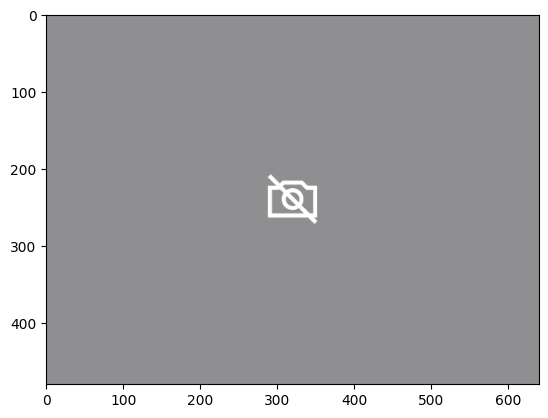

In [7]:
draw_styled_landmarks(frame,resuts)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

### 2.1 Test reading Keypoint from downloaded video

In [8]:
# test access to video file

cap = cv2.VideoCapture(r"C:\Users\Kokou\Documents\Project\Sign-Language-Detection\data\subset\cont\videos\CLSFB - 01 ok\CLSFBI0103A_S002_B.mp4") # device 0

# initialse detection confidence and then the confidence of tracking those detections
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic_model:

    while cap.isOpened():
        ret, frame = cap.read() # read one fream at this point of time

        # detection of the keypoint
        image, results = mp_detection(frame,holistic_model)
        draw_styled_landmarks(image,results)
        

        cv2.imshow("openCV feed cam", image) # window

        if cv2.waitKey(10) & 0xFF == ord('q'): # wait a key is pressed and check current key is 'q'
            break

    #release ressources
    cap.release()
    cv2.destroyAllWindows()



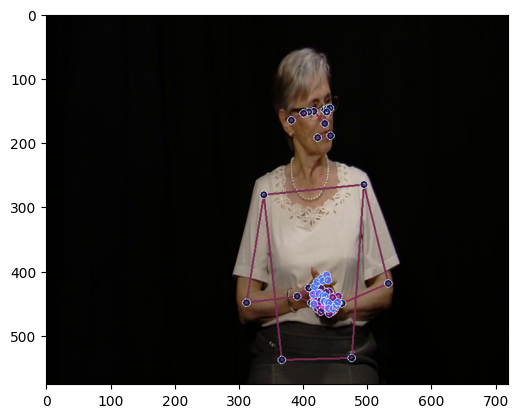

In [9]:
draw_styled_landmarks(frame,results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

## 3. Extract Keyoint Values

In [10]:
def extract_keypoints(results):
    """
    Extract all the key point from the results

    """
    # if no landmark for the hand => zeros array => no hand in teh frame
    # same idea for others part
    pose = np.array([[res.x,res.y,res.z,res.visibility]  for res in results.pose_landmarks.landmark ]).flatten() if results.pose_landmarks else np.zeros(33*4)
    left_hand = np.array([[res.x,res.y,res.z]  for res in results.left_hand_landmarks.landmark ]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    right_hand = np.array([[res.x,res.y,res.z]  for res in results.right_hand_landmarks.landmark ]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    face  = np.array([[res.x,res.y,res.z]  for res in results.face_landmarks.landmark ]).flatten() if results.face_landmarks else np.zeros(468*3)
    return np.concatenate([pose, face,left_hand, right_hand])


In [11]:

extract_keypoints(results).shape == (468*3+33*4+21*3*2,)

True

## 4. Setup Folders for collection

In [12]:
# Using the keypoint to decode tghe sign language 
# set up folder to store keypoint associeted to a frame

DATA_PATH = os.path.join("MP_Data") # path for the data -> numpy arrays

actions = np.array(['aussi', 'oui', 'quoi']) # actions that we try to detect
no_sequences = 30 # 30 videos of data for each actions
sequence_length = 30 # 30 frames in length

# we collect 30 videos per action the each videos contains 30 frames of data 
# and each frame contains 1662 landmark values (3*30 sequences, 30 frames, 1662 landmark)


In [13]:
# create a folder for each action containing a folder for each fequence
for action in actions:
    for seq in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH,action,str(seq)))
        except:
            pass

## 5.  Collect Keypoint Values for testing and training

In [ ]:
# test access to video file

cap = cv2.VideoCapture(0) # device 0

# initialse detection confidence and then the confidence of tracking those detections
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic_model:

    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                    
                ret, frame = cap.read() # read one fream at this point of time

                # detection of the keypoint
                image, results = mp_detection(frame,holistic_model)
                draw_styled_landmarks(image,results)
                
                if frame_num == 0:
                    cv2.putText(image, "STARTING COLLECTION", (120,200), cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),4,cv2.LINE_AA)
                    cv2.putText(image, f"Collection frames for {action} video Number {sequence}", (15,12), cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                    cv2.imshow("openCV feed cam", image) # window
                    
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, f"Collection frames for {action} video Number {sequence}", (15,12), cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)

                    cv2.imshow("openCV feed cam", image) # window
                
                #save keypoint in file
                keypoint = extract_keypoints(results)
                np_file_path = os.path.join(DATA_PATH,action,str(sequence), str(frame_num))
                np.save(np_file_path,keypoint)

                if cv2.waitKey(10) & 0xFF == ord('q'): # wait a key is pressed and check current key is 'q'
                    break

        #release ressources
        cap.release()
        cv2.destroyAllWindows()



In [ ]:
#Read video files downloaded (isol files) and get the landmark associeted 
BASE_PATH = "./../data/subset/isol/videos/"

# initialse detection confidence and then the confidence of tracking those detections
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic_model:

    for action in actions:
        video_files = os.listdir(os.path.join(BASE_PATH,"_"+str(action).upper()+"_"))
        sequence = 0
        while sequence != no_sequences:
            file = os.path.join(BASE_PATH,"_"+str(action).upper()+"_",video_files[sequence])
            cap = cv2.VideoCapture(file) # device 0

            for frame_num in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
                    
                ret, frame = cap.read() # read one fream at this point of time

                # detection of the keypoint
                if not None:
                    image, results = mp_detection(frame,holistic_model)
                    draw_styled_landmarks(image,results)
                    cv2.imshow("openCV feed", image) # window
                
                #save keypoint in file
                keypoint = extract_keypoints(results)
                np_file_path = os.path.join(DATA_PATH,action,str(sequence), str(frame_num))
                np.save(np_file_path,keypoint)

                if cv2.waitKey(10) & 0xFF == ord('q'): # wait a key is pressed and check current key is 'q'
                    break
            sequence +=1 # next file

    #release ressources
    cap.release()
    cv2.destroyAllWindows()



## 6. Preprocess Data and creeate Labels and features

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical #convert data into one hot encoded data

In [ ]:
label_map = {label:num for num,label in enumerate(actions)}
sequences = [] # represent the feature data X
labels = [] # represente the Y data

for action in actions:
    for sequence in range(no_sequences):
        window = []

        for frame_num in range(sequence_length):

            res = np.load(os.path.join(DATA_PATH,action,str(sequence), f"{frame_num}.npy"))
            window.append(res)
        sequences.append(window) # containt 90 differente video 3 words * 30 videos
        labels.append(label_map[action])

X = np.array(sequence)
y = to_categorical(labels).astype(int) # convert label to binary version

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [ ]:
X_train, X_test, y_train, y_test, = train_test_split(X,y,test_size=0.05)